In [26]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import os
from numpy import linalg as LA

In [27]:
#pip install rocketlogger

In [28]:
from rocketlogger.data import RocketLoggerData

# Configuration

In [29]:
# Export figure settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['ps.useafm'] = True

# constants
LPM_CURRENT_THRESHOLD = 30e-6 # ampere

QUANTILE = np.array([0.95, 0.99])
PERCENTILE = 100 * QUANTILE

TRIM_START = 3.0 # seconds
TRIM_END = 1.0 # seconds

APP_STATES = {
    0b0001: 'config',
    0b0011: 'BLE',
}

# print defined app states
print('Application states:')
for (index, name) in APP_STATES.items():
    print('{:4d}:\t{}'.format(index, name))
    
# input folder
input_folder = os.path.join('.')

# input files
measurement_file = 'data/mirocard_triggered_data_app.rld'

Application states:
   1:	config
   3:	BLE


# Load data

In [30]:
data = RocketLoggerData(os.path.join(input_folder, measurement_file))
data = data.merge_channels(True)
data_sample_rate = int(data._header['sample_rate'])
data_comment = data.get_comment()

In [31]:
print('__ File comment: __\n', data_comment)

__ File comment: __
 Energy characterization of the MiroCard BLE application with constant power supply at 4.5V acting as battery and frequent external trigger from a signal generator (2.5V at 50 Hz).
V1: Supply voltage of HARVESTER, Vcap
I1: Supply current of DUT (positive polarity)
DI1: GPIO indicating the application is running
DI2: GPIO indicating BLE is on
DI3: External trigger signal
All other signals are unused.


In [32]:
# RAW DATA
I_app = data.get_data('I1').squeeze()[int(TRIM_START*data_sample_rate):-int(TRIM_END*data_sample_rate)]
V_app = data.get_data('V1').squeeze()[int(TRIM_START*data_sample_rate):-int(TRIM_END*data_sample_rate)]

print("Average supply voltage:  {:1.2f} V ".format(np.mean(V_app)))

# DIO
# APP STATE
app_cycle = data.get_data('DI1').squeeze()[int(TRIM_START*data_sample_rate):-int(TRIM_END*data_sample_rate)] > 0
app_tx = data.get_data('DI2').squeeze()[int(TRIM_START*data_sample_rate):-int(TRIM_END*data_sample_rate)] > 0
app_state = np.array(0b0001 * app_cycle | 0b0010 * app_tx , dtype=np.uint8)

# EXTERNAL TRIGGER
app_wakeup = data.get_data('DI3').squeeze()[int(TRIM_START*data_sample_rate):-int(TRIM_END*data_sample_rate)]

# TIME
t_app = data.get_time()[int(TRIM_START*data_sample_rate):-int(TRIM_END*data_sample_rate)]
t_app = t_app - t_app[0]
dt_app = np.hstack([np.diff(t_app), 0])

# POWER / ENERGY
P_app = 1 * V_app * I_app
E_app = P_app * dt_app
E_app_masked = E_app * app_cycle #only taking into account active cycle
E_tx_masked = E_app * app_tx #only taking into account active cycle

Average supply voltage:  2.81 V 


# Extract Application states

In [33]:
# extract wakeup triggers
app_trig = np.diff(np.hstack([[0], app_wakeup])) > 0
app_trig_index = np.nonzero(app_trig)[0]
num_trig = len(app_trig_index)
print('Application executions: ', num_trig)

Application executions:  71


In [34]:
# extract LPM periods
app_lpm_window = (I_app) < LPM_CURRENT_THRESHOLD

# only consider lpm with at least on neighboring lpm (exclude single outliers)
app_lpm_window_filtered = np.logical_and(app_lpm_window, np.logical_or(np.hstack([app_lpm_window[1:], True]), np.hstack([True, app_lpm_window[:-1]])))

#if two activations are within this time [ms], then they are joined.
min_threshold_ms = 5
min_threshold = min_threshold_ms/1000*data_sample_rate

for t in range(num_trig-1):
    idx_start_i1 = app_trig_index[t]
    idx_start_i2 = app_trig_index[t+1]
    if( (idx_start_i2-idx_start_i1) < min_threshold):
        print("Successive triggers are too close at t={}".format(t))

lpm_enter_edge = np.diff(np.hstack([[0], app_lpm_window_filtered])) > 0
lpm_enter_index = np.nonzero(lpm_enter_edge)[0]

DEBUG at index 0
318080 318628 548
[ 0.21744264  0.16283435  0.11117997  0.06437636  0.02309974 -0.01703698]
[False False False  True  True  True]
[False False False  True  True  True]


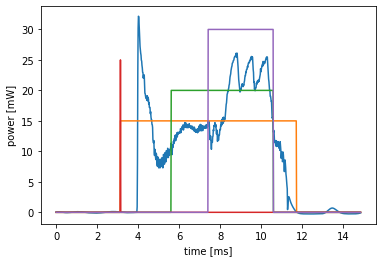

DEBUG at index 70
1175348 1175868 520
[ 1.88752936  2.01984593  3.41698309 -2.89975651 -1.68623217 -1.47331976]
[False False False  True  True  True]
[False False False  True  True  True]


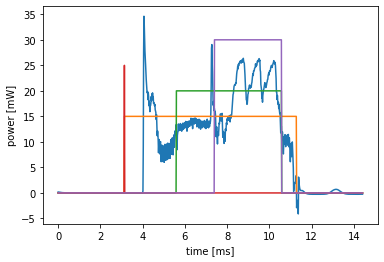

In [35]:
# calculate app active windows
app_active = np.zeros_like(app_trig, dtype=np.bool_)
app_active_index = np.zeros([num_trig, 2], dtype=np.int32)
app_rf_index = np.zeros([num_trig, 2], dtype=np.int32)
app_shutdown_index = np.zeros([num_trig, 2], dtype=np.int32)

for t in range(num_trig):
    idx_start = app_trig_index[t]
    idx_end = lpm_enter_index[lpm_enter_index > idx_start + data_sample_rate/1000]
        
    if (len(idx_end) == 0):
        print('skiping execution #{}'.format(t))
        continue
    else:
        idx_end = idx_end[0]

    if ((idx_end-idx_start) < min_threshold):
        print("Short inter-arrival time ({:.2f} ms) at t={}".format(1000*(idx_end-idx_start)/data_sample_rate,t))
        
    app_active[idx_start:idx_end] = True
    app_active_index[t] = [idx_start, idx_end]
    
    # debug plots (print a few to see if they make sense)
    if t in [0, num_trig-1]:
        print('DEBUG at index {}'.format(t))
        print(idx_start, idx_end, (idx_end - idx_start))
        print(1e3 * P_app[idx_end + range(-3, 3)])
        print(app_lpm_window[idx_end + range(-3, 3)])
        print(app_lpm_window_filtered[idx_end + range(-3, 3)])
        
        detail_range = range(max(0, idx_start-200), min(len(t_app)-1, idx_end+200))
        _ = plt.plot(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 1e3 * P_app[detail_range]) #blue
        _ = plt.plot(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 15 * app_active[detail_range]) #yellow
        _ = plt.plot(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 20 * app_cycle[detail_range]) #green
        _ = plt.plot(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 25 * app_trig[detail_range]) #red
        _ = plt.plot(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 30 * app_tx[detail_range]) #purple
        _ = plt.xlabel('time [ms]')
        _ = plt.ylabel('power [mW]')
        plt.show()

In [36]:
# extract application state and task active windows
app_state_windows = {}
app_process_window = np.zeros_like(app_state, dtype=np.bool_)
for (index, name) in APP_STATES.items():
    app_state_windows[index] = (app_state == index)
    app_process_window = np.logical_or(app_process_window, app_state_windows[index])
    print('{:>10s} : {:6}'.format(name, app_state_windows[index].sum()))

# derive init and shutdown masks
app_process_start = np.diff(np.hstack([[0], app_process_window])) > 0
app_init_window = np.cumsum(1 * app_trig - 1 * app_process_start) - np.sum(1 * app_trig - 1 * app_process_start)

# app_shutdown_window = np.logical_not(np.logical_or(app_init_window, np.logical_or(app_task_window, app_lpm_window_filtered)))
app_shutdown_window = np.logical_and(app_active, np.logical_not(np.logical_or(app_process_window, app_init_window)))

    config :   8159
       BLE :  14399


Range:
1175284
1175988


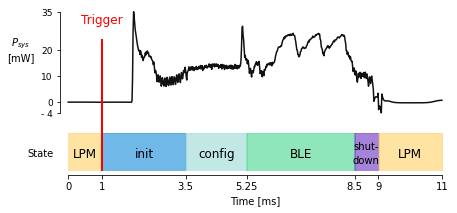

In [37]:
# detail view of imported data
SAMPLE_TRIG_INDEX = 70
detail_range = range(app_trig_index[SAMPLE_TRIG_INDEX] - int(0.001 * data_sample_rate), app_trig_index[SAMPLE_TRIG_INDEX] + int(0.010 * data_sample_rate))

print("Range:")
print(app_trig_index[SAMPLE_TRIG_INDEX] - int(0.001 * data_sample_rate))
print( app_trig_index[SAMPLE_TRIG_INDEX] + int(0.010 * data_sample_rate))

x_size = 7
power_plot = 0
state_plot = 1
init_begin = 1e3*t_app[np.argwhere(app_init_window[detail_range]==1)[0]][0]
config_begin = 1e3*t_app[np.argwhere(app_state_windows[1][detail_range]==1)[0]][0]
ble_begin = 1e3*t_app[np.argwhere(app_state_windows[3][detail_range]==1)[0]][0]
shutdown_begin = 1e3*t_app[np.argwhere(app_shutdown_window[detail_range]==1)[0]][0]
shutdown_end = 1e3*t_app[np.argwhere(app_shutdown_window[detail_range]==1)[-1]][0]
lpm_end = 1e3*t_app[np.argwhere(np.logical_not(app_active)[detail_range]==1)[-1]][0]
ptrace_color = '#111111'

fig, ax = plt.subplots(2, 1, figsize=(x_size, 3), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
_ = ax[power_plot].plot(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 1e3 * P_app[detail_range], color = ptrace_color)
_ = ax[power_plot].set_ylabel('$P_{sys}$\n[mW]', rotation = 'horizontal', labelpad = 20)
_ = ax[power_plot].spines['top'].set_visible(False)
_ = ax[power_plot].spines['right'].set_visible(False)
_ = ax[power_plot].spines['bottom'].set_visible(False)
_ = ax[power_plot].xaxis.set_tick_params(length = 0)
_ = ax[power_plot].spines['left'].set_bounds(min(1e3 * P_app[detail_range]), max(1e3 * P_app[detail_range]))
_ = ax[power_plot].set_yticks([min(1e3 * P_app[detail_range]), 0, 10, 20, max(1e3 * P_app[detail_range])])
_ = ax[power_plot].set_yticklabels(['- 4', '0', '10', '20', '35'], size = 9)
_ = ax[power_plot].text(0.38, 30, "Trigger", color = "red", fontsize = 12)


_ = ax[state_plot].fill_between(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 0, app_init_window[detail_range], step='mid', label='init', alpha=0.6, color ='#108AD9')
_ = ax[state_plot].fill_between(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 0, app_state_windows[1][detail_range], step='mid', label='config', alpha=0.6, color ='#98D9D3')
_ = ax[state_plot].fill_between(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 0, app_state_windows[3][detail_range], step='mid', label='ble', alpha=0.6, color = '#44D68C')
_ = ax[state_plot].fill_between(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 0, app_shutdown_window[detail_range], step='mid', label='shutdown', alpha=0.6, color ='#6930c3')
_ = ax[state_plot].fill_between(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 0, np.logical_not(app_active)[detail_range], step='mid', label='LPM', alpha=0.6, color = '#ffd166')
_ = ax[state_plot].set_xlabel('Time [ms]')
_ = ax[state_plot].set_ylabel('State', rotation = 'horizontal', labelpad = 20)
_ = ax[state_plot].yaxis.set_label_coords(-0.05,0.3)
_ = ax[state_plot].text(init_begin/2 , 0.4, "LPM", fontsize = 12, horizontalalignment='center')
_ = ax[state_plot].text(init_begin + (config_begin - init_begin)/2, 0.4, "init", fontsize = 12, horizontalalignment='center')
_ = ax[state_plot].text(config_begin + (ble_begin - config_begin)/2, 0.4, "config", fontsize = 12, horizontalalignment='center')
_ = ax[state_plot].text(ble_begin + (shutdown_begin - ble_begin)/2, 0.4, "BLE", fontsize = 12, horizontalalignment='center')
_ = ax[state_plot].text(shutdown_begin + (shutdown_end - shutdown_begin)/2, 0.6, "shut-", fontsize = 10, horizontalalignment='center')
_ = ax[state_plot].text(shutdown_begin + (shutdown_end - shutdown_begin)/2, 0.25, "down", fontsize = 10, horizontalalignment='center')
_ = ax[state_plot].text(shutdown_end + (lpm_end - shutdown_end)/2, 0.4, "LPM", fontsize = 12, horizontalalignment='center')
_ = ax[state_plot].spines['right'].set_visible(False)
_ = ax[state_plot].spines['top'].set_visible(False)
_ = ax[state_plot].spines['left'].set_visible(False)
_ = ax[state_plot].spines['bottom'].set_position(('outward', 5))
_ = ax[state_plot].yaxis.set_tick_params(length = 0)
_ = ax[state_plot].set_yticklabels([])
_ = ax[state_plot].set_ylim([0.1,1])
_ = ax[state_plot].axvline(x=init_begin,ymin=0,ymax=3.5,c="red",linewidth=2,zorder=10, clip_on=False)
_ = ax[state_plot].set_xlim([min(1e3 * (t_app[detail_range] - t_app[detail_range].min())) - 0.25, max(1e3 * (t_app[detail_range] - t_app[detail_range].min())) + 0.25])
_ = ax[state_plot].set_xticks([0, init_begin, config_begin, ble_begin, shutdown_begin, shutdown_end, lpm_end])
_ = ax[state_plot].set_xticklabels(['0', '1', '3.5', '5.25', '8.5', '9', '11'])
_ = ax[state_plot].spines['bottom'].set_bounds(min(1e3 * (t_app[detail_range] - t_app[detail_range].min())), max(1e3 * (t_app[detail_range] - t_app[detail_range].min())))
plt.show()


# Energy and Time Statistics

In [38]:
# extract individual activation energies for the application states
APP_TOTAL_STATE = 999
app_analysis_states = {0: 'init', **APP_STATES, 99: 'shutdown', APP_TOTAL_STATE: 'total'}

# total state init
app_state_energy = {APP_TOTAL_STATE: np.zeros(num_trig)}
app_state_time = {APP_TOTAL_STATE: np.zeros(num_trig)}

# application state energies
for (index, name) in app_analysis_states.items():
    if index == APP_TOTAL_STATE:
        continue # accumulation of other states

    # get state dependent filter
    if name == 'init':
        app_state_filter = app_init_window
    elif name == 'shutdown':
        app_state_filter = app_shutdown_window
    else:
        app_state_filter = app_state_windows[index]

    # energy calculation
    app_state_energy[index] = np.zeros(num_trig) * np.NaN
    app_state_time[index] = np.zeros(num_trig) * np.NaN
    E_app_filtered = E_app * app_state_filter
    
    # per activation statistics
    for activation in range(num_trig):
        [idx_start, idx_end] = app_active_index[activation]
        app_state_energy[index][activation] = np.sum(E_app_filtered[idx_start:idx_end])
        app_state_time[index][activation] = np.sum(app_state_filter[idx_start:idx_end]) / data_sample_rate
    app_state_energy[APP_TOTAL_STATE] += app_state_energy[index]
    app_state_time[APP_TOTAL_STATE] += app_state_time[index]

# sleep state power
P_lpm = np.mean(P_app[np.logical_not(app_active)])
I_lpm = np.mean(I_app[np.logical_not(app_active)])

In [39]:
# per activation sum statistics
print('Per application section energy (averaged for {} executions)'.format(num_trig))
print('app state    |    mean    |   std dev |   median   | {:.0f}% quant | {:.0f}% quant'.format(PERCENTILE[0], PERCENTILE[1]))
print()
for (index, name) in app_analysis_states.items():
    if name == 'total':
        print()
    # calculations
    app_state = app_state_energy[index]
    app_state_mean = np.mean(app_state)
    app_state_median = np.median(app_state)
    app_state_std = np.std(app_state)
    app_state_err_abs = np.abs(app_state - app_state_mean)
    app_state_quantile1 = np.percentile(app_state_err_abs, PERCENTILE[0])
    app_state_quantile2 = np.percentile(app_state_err_abs, PERCENTILE[1])
    
    print('E_{:10s} | {:7.3f} uJ | {:6.3f} uJ | {:7.3f} uJ | {:6.3f} uJ | {:6.3f} uJ'.format(
        name, 1e6 * app_state_mean, 1e6 * app_state_std, 1e6 * app_state_median, 1e6 * app_state_quantile1, 1e6 * app_state_quantile2))

print()
print('P_lpm        | {:7.3f} uW'.format(1e6 * P_lpm))
print('I_lpm        | {:7.3f} uA'.format(1e6 * I_lpm))

Per application section energy (averaged for 71 executions)
app state    |    mean    |   std dev |   median   | 95% quant | 99% quant

E_init       |  20.662 uJ |  0.489 uJ |  20.607 uJ |  0.570 uJ |  1.608 uJ
E_config     |  44.450 uJ |  4.150 uJ |  45.298 uJ |  1.663 uJ | 19.963 uJ
E_BLE        |  99.891 uJ |  7.660 uJ | 101.557 uJ |  1.880 uJ | 36.583 uJ
E_shutdown   |  10.927 uJ |  1.054 uJ |  11.254 uJ |  0.651 uJ |  5.050 uJ

E_total      | 175.929 uJ | 12.547 uJ | 178.588 uJ |  3.635 uJ | 60.903 uJ

P_lpm        |   6.946 uW
I_lpm        |   2.474 uA


In [40]:
# per activation time statistics
print('Per application section time (averaged for {} executions)'.format(num_trig))
print()
print('app state    |    mean    |   std dev |   median   | {:.0f}% quant | {:.0f}% quant'.format(PERCENTILE[0], PERCENTILE[1]))
print()
for (index, name) in app_analysis_states.items():
    if name == 'total':
        print()
    # calculations
    app_state = app_state_time[index]
    app_state_mean = np.mean(app_state)
    app_state_median = np.median(app_state)
    app_state_std = np.std(app_state)
    app_state_err_abs = np.abs(app_state - app_state_mean)
    app_state_quantile1 = np.percentile(app_state_err_abs, PERCENTILE[0])
    app_state_quantile2 = np.percentile(app_state_err_abs, PERCENTILE[1])
    
    print('t_{:10s} | {:7.3f} ms | {:6.3f} ms | {:7.3f} ms | {:6.3f} ms | {:6.3f} ms'.format(
        name, 1e3 * app_state_mean, 1e3 * app_state_std, 1e3 * app_state_median, 1e3 * app_state_quantile1, 1e3 * app_state_quantile2))

Per application section time (averaged for 71 executions)

app state    |    mean    |   std dev |   median   | 95% quant | 99% quant

t_init       |   2.177 ms |  0.067 ms |   2.156 ms |  0.021 ms |  0.315 ms
t_config     |   1.796 ms |  0.004 ms |   1.797 ms |  0.014 ms |  0.014 ms
t_BLE        |   3.169 ms |  0.006 ms |   3.172 ms |  0.013 ms |  0.013 ms
t_shutdown   |   1.021 ms |  0.167 ms |   1.109 ms |  0.318 ms |  0.338 ms

t_total      |   8.162 ms |  0.176 ms |   8.250 ms |  0.342 ms |  0.409 ms


In [24]:
# some analysis sanity checks
windows_agg = np.sum(app_init_window + sum(app_state_windows.values()) + app_shutdown_window + 1*np.logical_not(app_active))
print('window aggregation check:\t{}\t{} <> {}'.format(windows_agg == len(E_app), windows_agg, len(E_app)))

E_tot = np.sum(app_state_energy[APP_TOTAL_STATE]) + P_lpm * np.sum(dt_app[np.logical_not(app_active)])
print('energy conservation check:\t{}\t{} <> {}'.format(abs(np.sum(E_app) - E_tot) < 10e-9, E_tot, np.sum(E_app)))

window aggregation check:	True	1728000 <> 1728000
energy conservation check:	True	0.01267514889434861 <> 0.012675149839832239


##### 